# Exploration 11. 인공지능 작사가 만들기.

**Import**

In [1]:
import os 
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split  # 기본 세팅을 한다. os와 glob이 새로운 놈들이다.

In [2]:
# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어온다.
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 바꾸고 양쪽 공백을 삭제 했다.

    # 아래의 3 단계를 거쳐서 sentence는 스페이스 1 개를 delimeter로 하는 소문자 단어 시퀀스로 바뀐다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)    # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가.
    sentence = re.sub(r'[" "]+', " ", sentence)            # 공백 패턴을 만나면 스페이스 1개로 치환.
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환.

    sentence = sentence.strip()

    sentence = '<start>' + sentence + ' <end>'             # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와<end>를 단어처럼 붙여 준다. 

    return sentence

In [4]:
def tokenize(corpus):
  # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
      num_words=7000,  # 전체 단어의 개수
      filters=' ',     # 별도로 전처리 로직을 추가 할 수 있다. 이번엔는 사용하지 않는다.
      oov_token="<unk>"# out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
  )
    tokenizer.fit_on_texts(corpus) 
                       # 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 된다.
    tensor = tokenizer.texts_to_sequences(corpus)
                       # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor 로 변환.
                       # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding 메소드를 제공.
                       # maxlen의 디폴트 값은 none.  이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰진다.

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)

    print(tensor,tokenizer)
    return tensor, tokenizer       

In [5]:
def plot_curve(epochs, hist, list_of_metrics):

    fig, ax = plt.subplots(1,2,figsize = (12, 8))

    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')

        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')      
    plt.show()                
                            

In [6]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence 도 일단 텐서로 변환한다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할 때는 루프를 돌면서 단어 하나씩 생성해야 한다.
    while True:
        predict = model(test_tensor) # 입력받은 문장의 텐서를 입력한다.
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
                                    
                                     # 우리 모델이 예측한 마지막 단어를 입력문장의 뒤에 붙여준다.
        test_tensor = tf.concat([test_tensor,
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측했거나, max_len에 도달하지 않았다면 while 루프를 또 돌면서 다음 단어를 예측해야 한다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.indez_word 사전을 통해 실제 단어로 하나씩 변환한다.
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated  # 이것이 최종적으로 모델이 생성한 자연어 문장이다.    
                                     


# Dataset

In [7]:
txt_file_path = '/content/drive/MyDrive/aiffel/lyricist/data/lyrics/*'
# 경로를 불러올 때 마다 실수 투성이이다. 이번에는 구글드라이브에 옮겼다가 가져온다.
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.

for txt_file in txt_list:
    with open(txt_file, "r") as f:
      raw = f.read().splitlines()
      raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])      

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


# Data Preprocessing



In [8]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start>looking for some education <end>',
 '<start>made my way into the night <end>',
 '<start>all that bullshit conversation <end>',
 '<start>baby , can t you read the signs ? i won t bore you with the details , baby <end>',
 '<start>i don t even wanna waste your time <end>',
 '<start>let s just say that maybe <end>',
 '<start>you could help me ease my mind <end>',
 '<start>i ain t mr . right but if you re looking for fast love <end>',
 '<start>if that s love in your eyes <end>',
 '<start>it s more than enough <end>']

In [9]:
tensor, tokenizer = tokenize(corpus)

[[1248   29  111 ...    0    0    0]
 [2251   13   84 ...    0    0    0]
 [ 141   17 1225 ...    0    0    0]
 ...
 [  10   57  115 ...    0    0    0]
 [1220  811  113 ...    0    0    0]
 [  19   60   13 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f38a35741d0>


In [10]:
src_input = tensor[:, :-1]    # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습다.
tgt_input = tensor[:, 1:]     # tensor에서 <START>를 잘라내서 타겟 문장을 생성한다.

print(src_input[0])
print(tgt_input[0])

[1248   29  111 5671    2    0    0    0    0    0    0    0    0    0]
[  29  111 5671    2    0    0    0    0    0    0    0    0    0    0]


In [11]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=2020)

In [12]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

# Model

In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 2048
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [16]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[-2.36661566e-04,  6.10262505e-04, -7.91068451e-05, ...,
          3.52213276e-04, -1.23382022e-03,  7.60795547e-06],
        [-4.54970199e-04,  1.20507379e-03,  6.65117041e-05, ...,
          1.15269577e-04, -1.36611809e-03,  3.33167816e-04],
        [-1.12034869e-03,  1.15249399e-03,  5.20670146e-04, ...,
          6.07189781e-04, -1.24874583e-03, -3.20482039e-04],
        ...,
        [ 9.50512534e-04, -1.60094153e-03,  8.36144015e-03, ...,
          5.37763257e-03,  1.60840875e-03,  2.49824300e-03],
        [ 7.83437688e-04, -2.11916445e-03,  9.02945921e-03, ...,
          5.50457137e-03,  1.64675491e-03,  2.94811931e-03],
        [ 5.86260983e-04, -2.57099210e-03,  9.54719540e-03, ...,
          5.59502607e-03,  1.63452642e-03,  3.36419698e-03]],

       [[-1.05119555e-03, -1.78988965e-04,  5.94347948e-04, ...,
         -6.15678669e-04, -2.31035825e-04, -2.55611783e-04],
        [-1.66009599e-03,  1.83445081e-04,  1.

In [17]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  14338048  
                                                                 
 lstm (LSTM)                 multiple                  33562624  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 lstm_1 (LSTM)               multiple                  33562624  
                                                                 
 dense (Dense)               multiple                  14345049  
                                                                 
Total params: 95,808,345
Trainable params: 95,808,345
Non-trainable params: 0
_________________________________________________________________


# Train

In [18]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [19]:
history = model.fit(dataset,
          epochs=7,
          validation_data=val_dataset,
          verbose=1)  # 함수 인자로 verbose--> 함수 수행시 발생하는 상세한 정보들을 표준출력으로 자세히  내보냄.
                      # 보통 0은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력.

Epoch 1/7
549/549 [==============================] - 156s 280ms/step - loss: 2.9034 - accuracy: 0.5334 - val_loss: 2.5158 - val_accuracy: 0.5655
Epoch 2/7
549/549 [==============================] - 153s 279ms/step - loss: 2.3389 - accuracy: 0.5814 - val_loss: 2.2403 - val_accuracy: 0.5961
Epoch 3/7
549/549 [==============================] - 153s 279ms/step - loss: 2.0007 - accuracy: 0.6182 - val_loss: 2.0703 - val_accuracy: 0.6222
Epoch 4/7
549/549 [==============================] - 154s 279ms/step - loss: 1.6907 - accuracy: 0.6596 - val_loss: 1.9554 - val_accuracy: 0.6442
Epoch 5/7
549/549 [==============================] - 153s 279ms/step - loss: 1.4182 - accuracy: 0.7029 - val_loss: 1.8799 - val_accuracy: 0.6633
Epoch 6/7
549/549 [==============================] - 153s 279ms/step - loss: 1.1933 - accuracy: 0.7431 - val_loss: 1.8436 - val_accuracy: 0.6790
Epoch 7/7
549/549 [==============================] - 154s 280ms/step - loss: 1.0185 - accuracy: 0.7770 - val_loss: 1.8342 - val_ac

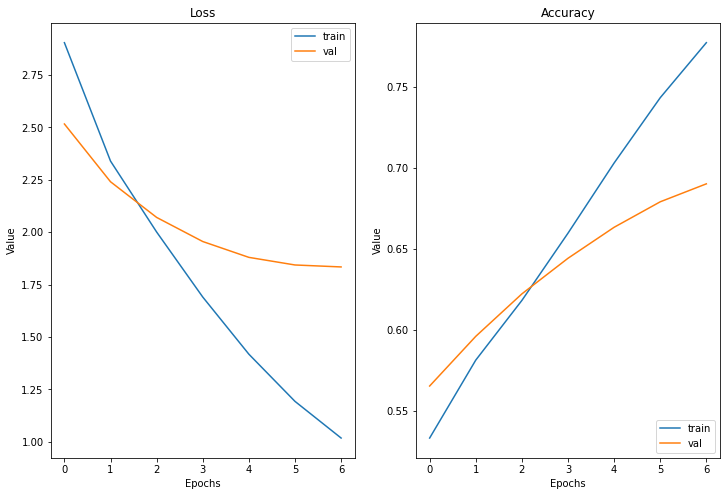

In [20]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Generate lyrics(가사 생성기?) 

In [21]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i need you <end> '

In [22]:
generate_text(model, tokenizer, init_sentence="<start> i am", max_len=20)

'<start> i am not a man , <end> '

# Report

Model
LSTM layer 사이에 Dropout(0.3)을 적용하였습니다.

embedding_size, hidden_size를 각각 다음과 같이 설정하였습니다.

embedding_size = 2048, hidden_size = 2048

나는 그냥 똑같이 따라서 배끼려고 했다.
그것도 어려웠다. 내 눈에는 진짜 똑 같은데, 돌아가지 않고 에러, 에러, 에러.



내가 코드를 그대로 따라 치려고 했던 이분의 Report에는 

***'최종적으로 val_loss를 2.1772을 얻었습니다.'::::***

라고 한다.

나는 무엇을 얻었나?

생각하고, 예측하고, 컴퓨터에게 맡기기 전에 미리 문제해결 방법을 꿰뚫어 보아야 한다는 것?

가까워 질수록 서먹서먹해 지는 인공지능과의 관계. . .

한 발 가까이, 오늘도 간다.

이 작업을 능숙하게, 고민하며, 결국 해 내고 나서 기뻐하는 분들을 본다. 앞으로가 기대된다. 나도 내일 한 발 더 나가면, 내 힘으로 작업을 끝내고 다른 사람도 도울 수 있으려나.. .




[링크 텍스트](https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%2011.%20%EC%9E%91%EC%82%AC%EA%B0%80%20%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb)